# Workflows cookbook: walking through all features of Workflows

First, we install our dependencies. Core contains most of what we need; OpenAI is to handle LLM access and utils-workflow provides the visualization capabilities we'll use later on.

In [ ]:
!pip install --upgrade llama-index-core llama-index-llms-openai llama-index-utils-workflow

Then we bring in the deps we just installed

In [ ]:
from llama_index.core.workflow import (
    Event,
    StartEvent,
    StopEvent,
    Workflow,
    step,
    Context,
)
import random
from llama_index.core.workflow import draw_all_possible_flows
from llama_index.utils.workflow import draw_most_recent_execution
from llama_index.llms.openai import OpenAI

Set up our OpenAI key, so we can do actual LLM things.

In [ ]:
import os
from google.colab import userdata

os.environ["OPENAI_API_KEY"] = userdata.get("openai-key")

## Workflow basics

Let's start with the basic possible workflow: it just starts, does one thing, and stops. There's no reason to have a real workflow if your task is this simple, but we're just demonstrating how they work.

In [ ]:
from llama_index.llms.openai import OpenAI


class OpenAIGenerator(Workflow):
    @step()
    async def generate(self, ev: StartEvent) -> StopEvent:
        llm = OpenAI(model="gpt-4o")
        response = await llm.acomplete(ev.query)
        return StopEvent(result=str(response))


w = OpenAIGenerator(timeout=10, verbose=False)
result = await w.run(query="What's LlamaIndex?")
print(result)

LlamaIndex, previously known as GPT Index, is a data framework designed to facilitate the connection between large language models (LLMs) and external data sources. It provides a suite of tools that enable LLMs to ingest, structure, and query data from various sources such as documents, databases, and APIs. This framework is particularly useful for applications that require LLMs to interact with and retrieve information from large and diverse datasets, enhancing their ability to generate accurate and contextually relevant responses.


One of the neat things about Workflows is that we can use pyvis to visualize them. Let's see what that looks like for this very simple flow.

In [ ]:
draw_all_possible_flows(OpenAIGenerator, filename="trivial_workflow.html")

trivial_workflow.html


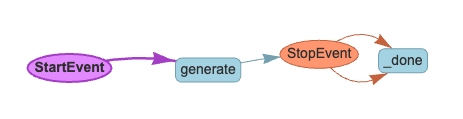

Not a lot to see here, yet! The start event goes to generate() and then straight to StopEvent.

## Loops and branches

Let's go to a more interesting example, demonstrating our ability to loop:

In [ ]:
class FailedEvent(Event):
    error: str


class QueryEvent(Event):
    query: str


class LoopExampleFlow(Workflow):
    @step()
    async def answer_query(
        self, ev: StartEvent | QueryEvent
    ) -> FailedEvent | StopEvent:
        query = ev.query
        # try to answer the query
        random_number = random.randint(0, 1)
        if random_number == 0:
            return FailedEvent(error="Failed to answer the query.")
        else:
            return StopEvent(result="The answer to your query")

    @step()
    async def improve_query(self, ev: FailedEvent) -> QueryEvent | StopEvent:
        # improve the query or decide it can't be fixed
        random_number = random.randint(0, 1)
        if random_number == 0:
            return QueryEvent(query="Here's a better query.")
        else:
            return StopEvent(result="Your query can't be fixed.")

We're using random numbers to simulate LLM actions here so that we can get reliably interesting behavior.

answer_query() accepts a start event. It can then do 2 things:
* it can answer the query and emit a StopEvent, which returns the result
* it can decide the query was bad and emit a FailedEvent

improve_query() accepts a FailedEvent. It can also do 2 things:
* it can decide the query can't be improved and emit a StopEvent, which returns failure
* it can present a better query and emit a QueryEvent, which creates a loop back to answer_query()

We can also visualize this more complicated workflow:

In [ ]:
draw_all_possible_flows(LoopExampleFlow, filename="loop_workflow.html")

loop_workflow.html


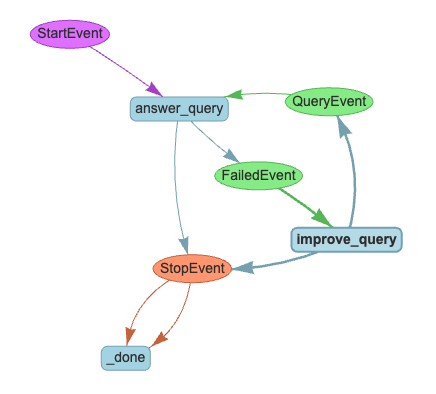

We've set `verbose=True` here so we can see exactly what events were triggered. You can see it conveniently demonstrates looping and then answering.

In [ ]:
l = LoopExampleFlow(timeout=10, verbose=True)
result = await l.run(query="What's LlamaIndex?")
print(result)

Running step answer_query
Step answer_query produced event FailedEvent
Running step improve_query
Step improve_query produced event QueryEvent
Running step answer_query
Step answer_query produced event FailedEvent
Running step improve_query
Step improve_query produced event QueryEvent
Running step answer_query
Step answer_query produced event StopEvent
The answer to your query


## Maintaining state between events

There is a global state which allows you to keep arbitrary data or functions around for use by all event handlers.

In [ ]:
class GlobalExampleFlow(Workflow):
    @step(pass_context=True)
    async def setup(self, ctx: Context, ev: StartEvent) -> QueryEvent:
        # load our data here
        ctx.data["some_database"] = ["value1", "value2", "value3"]

        return QueryEvent(query=ev.query)

    @step(pass_context=True)
    async def query(self, ctx: Context, ev: QueryEvent) -> StopEvent:
        # use our data with our query
        data = ctx.data["some_database"]

        result = f"The answer to your query is {data[1]}"
        return StopEvent(result=result)

In [ ]:
g = GlobalExampleFlow(timeout=10, verbose=True)
result = await g.run(query="What's LlamaIndex?")
print(result)

Running step setup
Step setup produced event QueryEvent
Running step query
Step query produced event StopEvent
The answer to your query is value2


Of course, this flow is essentially still linear. A more realistic example would be if your start event could either be a query or a data population event, and you needed to wait. Let's set that up to see what it looks like:

In [ ]:
class WaitExampleFlow(Workflow):
    @step(pass_context=True)
    async def setup(self, ctx: Context, ev: StartEvent) -> StopEvent:
        if hasattr(ev, "data"):
            ctx.data["some_database"] = ev.data

        return StopEvent(result=None)

    @step(pass_context=True)
    async def query(self, ctx: Context, ev: StartEvent) -> StopEvent:
        if hasattr(ev, "query"):
            # do we have any data?
            if "some_database" in ctx.data:
                data = ctx.data["some_database"]
                return StopEvent(result=f"Got the data {data}")
            else:
                # there's non data yet
                return None
        else:
            # this isn't a query
            return None

In [ ]:
w = WaitExampleFlow(verbose=True)
result = await w.run(query="Can I kick it?")
if result is None:
    print("No you can't")
print("---")
result = await w.run(data="Yes you can")
print("---")
result = await w.run(query="Can I kick it?")
print(result)

Running step query
Step query produced no event
Running step setup
Step setup produced event StopEvent
No you can't
---
Running step query
Step query produced no event
Running step setup
Step setup produced event StopEvent
---
Running step query
Step query produced event StopEvent
Running step setup
Step setup produced event StopEvent
Got the data Yes you can


Let's visualize how this flow works:

In [ ]:
draw_all_possible_flows(WaitExampleFlow, filename="wait_workflow.html")

wait_workflow.html


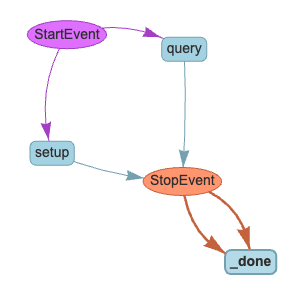

## Waiting for one or more events

Because waiting for events is such a common pattern, the context object has a convenience function, `collect_events()`. It will capture events and store them, returning `None` until all the events it requires have been collected. Those events will be attached to the output of `collect_events` in the order that they were specified. Let's see this in action:

In [ ]:
class InputEvent(Event):
    input: str


class SetupEvent(Event):
    error: bool


class QueryEvent(Event):
    query: str


class CollectExampleFlow(Workflow):
    @step(pass_context=True)
    async def setup(self, ctx: Context, ev: StartEvent) -> SetupEvent:
        # generically start everything up
        if "setup" not in ctx.data:
            ctx.data["setup"] = True
            print("I got set up")
            return SetupEvent(error=False)

    @step()
    async def collect_input(self, ev: StartEvent) -> InputEvent:
        if hasattr(ev, "input"):
            # perhaps validate the input
            print("I got some input")
            return InputEvent(input=ev.input)

    @step()
    async def parse_query(self, ev: StartEvent) -> QueryEvent:
        if hasattr(ev, "query"):
            # parse the query in some way
            print("I got a query")
            return QueryEvent(query=ev.query)

    @step(pass_context=True)
    async def run_query(
        self, ctx: Context, ev: InputEvent | SetupEvent | QueryEvent
    ) -> StopEvent:
        ready = ctx.collect_events(ev, [QueryEvent, InputEvent, SetupEvent])
        if ready is None:
            print("Not enough events yet")
            return StopEvent()

        # run the query
        print("Now I have all the events")
        print(ready)
        return StopEvent(
            result=f"Ran query {ready[0].query} on input {ready[1].input}"
        )

In [ ]:
c = CollectExampleFlow()
result = await c.run()
print("---")
result = await c.run(input="Here's some input")
print("---")
result = await c.run(query="Here's my question")
print(result)

I got set up
Not enough events yet
---
I got some input
Not enough events yet
---
I got a query
Now I have all the events
[QueryEvent(query="Here's my question"), InputEvent(input="Here's some input"), SetupEvent(error=False)]
Ran query Here's my question on input Here's some input


You can see each of the events getting triggered as well as the collection event repeatedly returning `None` until enough events have arrived. Let's see what this looks like in a flow diagram:

In [ ]:
draw_all_possible_flows(CollectExampleFlow, "collect_workflow.html")

collect_workflow.html


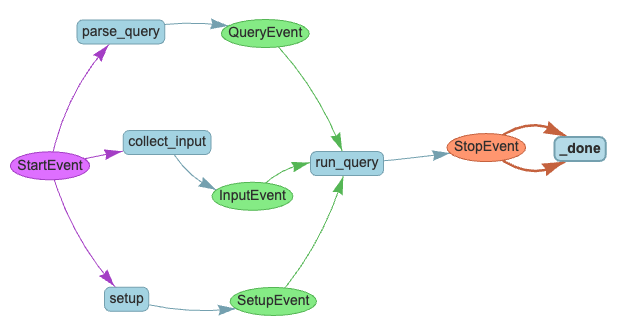

You can also collect multiple events of the same kind, for instance to monitor failures:

In [ ]:
class FailureEvent(Event):
    error: str


class FailureExampleFlow(Workflow):
    @step()
    async def try_to_do_thing(
        self, ev: StartEvent
    ) -> StopEvent | FailureEvent:
        random_number = random.randint(0, 10)
        if random_number < 5:
            print("There was a failure")
            return FailureEvent(
                error=f"This is the bad place: {random_number}"
            )
        else:
            print("There was success")
            return StopEvent(result="Success")

    @step(pass_context=True)
    async def monitor_failures(
        self, ctx: Context, ev: FailureEvent
    ) -> StopEvent | None:
        failed = ctx.collect_events(
            ev, [FailureEvent, FailureEvent, FailureEvent]
        )
        if failed is not None:
            print(failed)
            print("The simulation has failed!")
            return StopEvent(result="Failure")

        return StopEvent()

In [ ]:
f = FailureExampleFlow(verbose=False)
result = await f.run()
print("====", result)
result = await f.run()
print("====", result)
result = await f.run()
print("====", result)
result = await f.run()
print("====", result)
result = await f.run()
print("====", result)
result = await f.run()

There was a failure
==== None
There was success
==== Success
There was success
==== Success
There was success
==== Success
There was a failure
==== None
There was a failure
[FailureEvent(error='This is the bad place: 2'), FailureEvent(error='This is the bad place: 3'), FailureEvent(error='This is the bad place: 0')]
The simulation has failed!


As you can see, it didn't trigger system failure until the third failure event. The visualization here is again pretty simple.

In [ ]:
draw_all_possible_flows(FailureExampleFlow, "failure_workflow.html")

failure_workflow.html


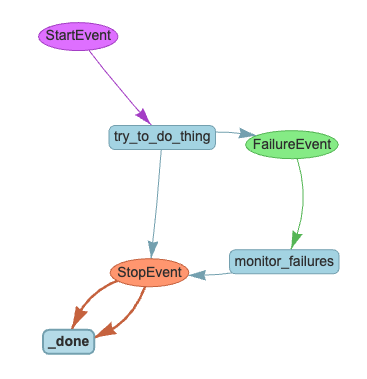

## Stepping through workflows

You can also walk through a workflow step-by-step:

In [ ]:
# Kick off the workflow
f3 = FailureExampleFlow(verbose=True)

In [ ]:
await f3.run_step()

Running step try_to_do_thing
There was a failure
Step try_to_do_thing produced event FailureEvent


In [ ]:
await f3.run_step()

Running step monitor_failures
Step monitor_failures produced event StopEvent


You can also use visualization to show just the most recent execution rather than all possible flows, even when the flow is mid-execution:

In [ ]:
draw_most_recent_execution(f3, "last_execution.html")

last_execution.html


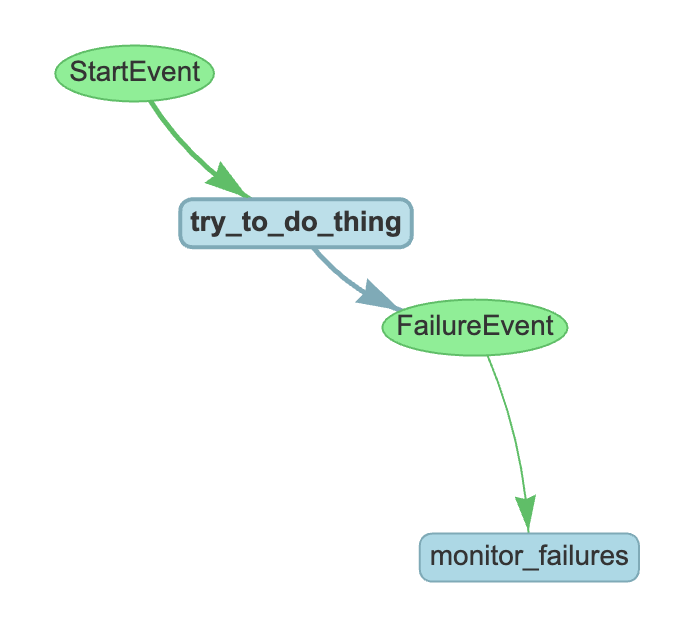

This concludes our tour of creating, running and visualizing workflows! Check out the [docs](https://docs.llamaindex.ai/en/stable/module_guides/workflow/) and [examples](https://docs.llamaindex.ai/en/stable/examples/workflow/function_calling_agent/) to learn more.